In [38]:
!python -V

Python 3.9.12


In [41]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# Initial setting for tracking uri:
MLflow setup:
- tracking server: yes, local server
- backend store: sqlite database
- artifacts store: local filesystem

-  to specify the tracking server URI to which MLflow will send logs, metrics, parameters, and artifacts. This allows you to direct MLflow to use different backends for storing your experiment data.

mlflow ui: Primarily for local, development, and single-user scenarios.

mlflow server: Designed for multi-user, production, and team-based scenarios.

In [43]:
import mlflow
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts_local
# mlflow ui --backend-store-uri sqlite:///mlflow.db
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("nyc-taxi-experiment")
print(f"tracking URI: {mlflow.get_tracking_uri()}")


2024/05/28 07:16:33 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


tracking URI: http://127.0.0.1:5000


# Basic Data Analysis - DS Work

In [44]:
# Goal: Predict the duration of taxi trip
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [45]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464278878395

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


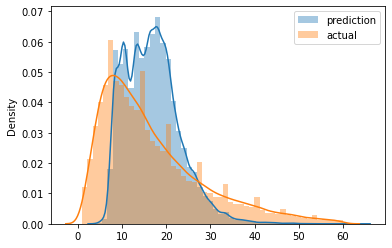

In [46]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [47]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [48]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [49]:
len(df_train), len(df_val)

(73908, 61921)

In [50]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [51]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [52]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.4793657829373155

In [54]:
# Save trained model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## Basic Usage of MLFlow
- sstart_run: start a new MLflow run, setting it as the active run under which metrics and parameters will be logged
- log_param: log a parameter
- log_metric: log a metric
- log_artifact: log a local file or directory as an artifact of the current active run

In [55]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "henry")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [77]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [78]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [79]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=5,
            evals=[(valid, 'validation')],
            early_stopping_rounds=20
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [80]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0)
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:14:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77578                         
[1]	validation-rmse:11.36893                         
[2]	validation-rmse:10.99092                         
[3]	validation-rmse:10.64077                         
[4]	validation-rmse:10.31494                         
 20%|██        | 1/5 [00:32<02:11, 32.83s/trial, best loss: 10.314936471583328]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:14:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.88571                                                    
[1]	validation-rmse:8.49263                                                    
[2]	validation-rmse:7.69515                                                    
[3]	validation-rmse:7.24852                                                    
[4]	validation-rmse:7.00009                                                    
 40%|████      | 2/5 [00:37<00:48, 16.10s/trial, best loss: 7.000086100506312] 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:14:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.22948                                                   
[1]	validation-rmse:7.76683                                                   
[2]	validation-rmse:7.09953                                                   
[3]	validation-rmse:6.78795                                                   
[4]	validation-rmse:6.64344                                                   
 60%|██████    | 3/5 [00:51<00:30, 15.48s/trial, best loss: 6.64344128510275] 

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:15:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.47777                                                 
[1]	validation-rmse:10.83262                                                 
[2]	validation-rmse:10.26168                                                 
[3]	validation-rmse:9.76218                                                  
[4]	validation-rmse:9.32441                                                  
[0]	validation-rmse:7.16481                                                  
[1]	validation-rmse:6.84557                                                  
 80%|████████  | 4/5 [01:23<00:21, 21.55s/trial, best loss: 6.64344128510275]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:15:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.81044                                                  
[3]	validation-rmse:6.80299                                                  
[4]	validation-rmse:6.79608                                                  
100%|██████████| 5/5 [01:23<00:00, 16.70s/trial, best loss: 6.64344128510275]


In [81]:
# automatic logging allows you to log metrics, parameters, 
# and models without the need for explicit statements.
mlflow.xgboost.autolog(disable=True)

In [88]:
# After the previous step to find out optimized parameters, 
# then run the model to check
with mlflow.start_run(run_name="Optimized_Model"):
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:33:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:34:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


#### From MLflow, we can get the ID to pull the saved model

In [84]:
logged_model = 'runs:/fc0b9298cefc435dabf130cdf0b4e937/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:24:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: fc0b9298cefc435dabf130cdf0b4e937

In [85]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:24:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

Now, deployment engineer will take a loow at the registry will decide which model should be promoted

In [14]:
# Create Client
import mlflow
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [16]:
# search experiments
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716671573394, experiment_id='1', last_update_time=1716671573394, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1716671481841, experiment_id='0', last_update_time=1716671481841, lifecycle_stage='active', name='Default', tags={}>]

In [17]:
# create experiment through code
client.create_experiment(name="my-cool-experiment")

'2'

In [19]:
# find run with certain condition through experiment
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"] # query format <, > etc
)


In [43]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: a2d064c6c2cc4c94b92e0acb74f06b6d, rmse: 2.7187
run id: 823520d0958947bf889b31728b87dd16, rmse: 6.4798
run id: e030c3664670441bab114a17dc7f4236, rmse: 6.4798
run id: fc0b9298cefc435dabf130cdf0b4e937, rmse: 6.4798
run id: d72510bec7ef4303a9cacaac5508ee10, rmse: 6.6434


In [21]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [46]:
# Register Model
run_id = "823520d0958947bf889b31728b87dd16"
model_url = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_url, name="nyc-taxi-regressor")

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '5' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1716704933169, current_stage='None', description=None, last_updated_timestamp=1716704933169, name='nyc-taxi-regressor', run_id='823520d0958947bf889b31728b87dd16', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/823520d0958947bf889b31728b87dd16/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=5>

In [47]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1716673000472, description='The NYC taxi predictor for trip duration', last_updated_timestamp=1716704933169, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1716673000557, current_stage='Production', description='', last_updated_timestamp=1716702804656, name='nyc-taxi-regressor', run_id='823520d0958947bf889b31728b87dd16', run_link='', source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/823520d0958947bf889b31728b87dd16/artifacts/models_mlflow', status='READY', status_message=None, tags={'model': 'xgboost'}, user_id=None, version=1>,
  <ModelVersion: aliases=[], creation_timestamp=1716703677999, current_stage='Staging', description='The model version 3 was transitioned to Staging on 2024-05-26 06:16:16.809334', last_updated_timestamp=1716704176810, name='nyc-taxi-regressor', run_id='a2d064c6c2cc4c94b92e0acb74f06b6d', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/a2d064c6c2c

In [48]:
model_name = "nyc-taxi-regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, current_stage: {version.current_stage}")

version: 1, current_stage: Production
version: 3, current_stage: Staging
version: 5, current_stage: None


/tmp/ipykernel_2528/3415575904.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)


In [49]:
new_stage = "Staging"
model_version = 5
client.transition_model_version_stage(
    name = model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False

)

/tmp/ipykernel_2528/2492598423.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1716704933169, current_stage='Staging', description=None, last_updated_timestamp=1716704960492, name='nyc-taxi-regressor', run_id='823520d0958947bf889b31728b87dd16', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/823520d0958947bf889b31728b87dd16/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=5>

In [51]:
from datetime import datetime
date = datetime.today()
client.update_model_version(
    name=model_name,
    version=5,
    description=f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: aliases=[], creation_timestamp=1716704933169, current_stage='Staging', description='The model version 5 was transitioned to Staging on 2024-05-26 06:29:30.768487', last_updated_timestamp=1716704970770, name='nyc-taxi-regressor', run_id='823520d0958947bf889b31728b87dd16', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/823520d0958947bf889b31728b87dd16/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=5>

### Comparing versions and selecting the new "Production" model

In the last section, we will retrieve models registered in the model registry and compare their performance on an unseen test set. The idea is to simulate the scenario in which a deployment engineer has to interact with the model registry to decide whether to update the model version that is in production or not.

These are the steps:

1. Load the test dataset, which corresponds to the NYC Green Taxi data from the month of March 2021.
2. Download the `DictVectorizer` that was fitted using the training data and saved to MLflow as an artifact, and load it with pickle.
3. Preprocess the test set using the `DictVectorizer` so we can properly feed the regressors.
4. Make predictions on the test set using the model versions that are currently in the "Staging" and "Production" stages, and compare their performance.
5. Based on the results, update the "Production" model version accordingly.


**Note: the model registry doesn't actually deploy the model to production when you transition a model to the "Production" stage, it just assign a label to that model version. You should complement the registry with some CI/CD code that does the actual deployment.**

In [52]:
from sklearn.metrics import mean_squared_error
import pandas as pd


def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    train_dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(train_dicts)


def test_model(name, stage, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": mean_squared_error(y_test, y_pred, squared=False)}

In [53]:
df = read_dataframe("./data/green_tripdata_2021-03.parquet")

In [54]:
client.download_artifacts(
    run_id=run_id, 
    path='preprocessor', 
    dst_path='.')

'/workspaces/mlops-zoomcamp/02-experiment-tracking/preprocessor'

In [55]:
import pickle

with open("preprocessor/preprocessor.b", "rb") as f_in:
    dv = pickle.load(f_in)

In [56]:
X_test = preprocess(df, dv)
target = "duration"
y_test = df[target].values

In [ ]:
%time test_model(name=model_name, stage="Production", X_test=X_test, y_test=y_test)

In [ ]:
%time test_model(name=model_name, stage="Staging", X_test=X_test, y_test=y_test)

In [ ]:
client.transition_model_version_stage(
    name=model_name,
    version=5,
    stage="Production",
    archive_existing_versions=True
)